# Classification

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.


## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields


## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

In [1]:
## Import 
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


## Dataset

Download the dataset:

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


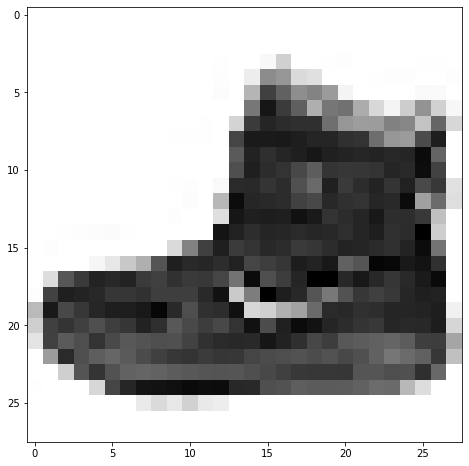

In [4]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [5]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [6]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


#Dataset

In [8]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True) #trasform=advance trasform

In [ ]:

#basic_transforms = transforms.Compose([
#                                    transforms.ToTensor(),
#                                    transforms.Normalize((0.1307,), (0.3081,))
#                                    ])
#
#test_dataset  = datasets.FashionMNIST('classifier_data', train=False, transform=basic_transforms, download=True)
#
#Gauss_noise = AddGaussianNoise()
#Rotation    = transforms.RandomRotation(degrees = 45)
#
#advanced_transform = transforms.Compose([basic_transforms,
#                                        transforms.RandomChoice([Gauss_noise,Rotation])
#                                        ]) 

In [9]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train

In [10]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: classifier_data
    Split: Test

In [17]:
#Obtain the validation dataset 
train_size= int(0.8*len(train_dataset))
val_size = len(train_dataset)-train_size
print(train_size,val_size)

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

#Dataloader

38400 9600


In [ ]:
batch_size = 100

#check num_workers
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=0)

# Model

In [7]:
! pip install pytorch-lightning

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 25.8 MB/s 
     |████████████████████████████████| 140 kB 69.7 MB/s 
     |████████████████████████████████| 596 kB 63.2 MB/s 
     |████████████████████████████████| 419 kB 53.1 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 271 kB 59.3 MB/s 
     |████████████████████████████████| 144 kB 78.0 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Define a LightningModule (nn.Module subclass)
# A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).
class LitNet(pl.LightningModule):
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.net =nn.Sequential(
                        #need to define a model for classification
                        nn.Conv2d(in_cannels=1, out_channels=4)
                       #nn.Linear(in_features=Ni, out_features=Nh1), 
                       #nn.ReLU(), 
                       #nn.Linear(in_features=Nh1, out_features=Nh2),
                       #nn.ReLU(),
                       #nn.Linear(in_features=Nh2, out_features=No))
        self.val_loss = []
        self.train_loss = []

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        return self.net(x)

    # Training_step defines the training loop. 
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        #loss = nn.MSELoss(out, label_batch)
        loss = F.mse_loss(out, label_batch)
        self.train_loss.append(loss.item()) #loss.item() instead of loss
        self.log("val_loss", loss.item())
        return loss

    def validation_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        #loss = nn.MSELoss(out, label_batch)
        loss = F.mse_loss(out, label_batch)
        self.val_loss.append(loss.item())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(), lr=1e-2)
        return optimizer

# Training